## Example plot for LFPy: Passive cell model adapted from Mainen and Sejnokwski (1996)
* https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-09.ipynb
* Here, excitatory and inhibitory neurons are distributed on different parts of the morphology, with stochastic spike times produced by the NEURON's NetStim objects associated with each individual synapse. Otherwise similar to 08_Passive_cell_model.ipynb

In [1]:
# importing some modules, setting some matplotlib values for pl.plot.
import LFPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

--No graphics will be displayed.


In [2]:
plt.rcParams.update({'font.size' : 12,
                     'figure.facecolor' : '1',
                     'figure.subplot.wspace' : 0.5,
                     'figure.subplot.hspace' : 0.5})

#seed for random generation
np.random.seed(1234)

In [3]:
def insert_synapses(synparams, section, n, netstimParameters):
    '''find n compartments to insert synapses onto'''
    idx = cell.get_rand_idx_area_norm(section=section, nidx=n)

    #Insert synapses in an iterative fashion
    for i in idx:
        synparams.update({'idx' : int(i)})

        # Create synapse(s) and setting times using the Synapse class in LFPy
        s = LFPy.Synapse(cell, **synparams)
        s.set_spike_times_w_netstim(**netstimParameters)

In [4]:
# Define cell parameters used as input to cell-class
cellParameters = {
    'morphology' : 'morphologies/L5_Mainen96_wAxon_LFPy.hoc',
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive' : True,           # switch on passive mechs
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params    
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 100,           # segments are isopotential at this frequency
    'dt' : 2**-4,               # dt of LFP and NEURON simulation.
    'tstart' : -100,          #start time, recorders start at t=0
    'tstop' : 200,            #stop time of simulation
    #'custom_code'  : ['active_declarations_example3.hoc'], # will run this file
}

In [5]:
# Synaptic parameters taken from Hendrickson et al 2011
# Excitatory synapse parameters:
synapseParameters_AMPA = {
    'e' : 0,                    #reversal potential
    'syntype' : 'Exp2Syn',      #conductance based exponential synapse
    'tau1' : 1.,                #Time constant, rise
    'tau2' : 3.,                #Time constant, decay
    'weight' : 0.005,           #Synaptic weight
    'record_current' : True,    #record synaptic currents
}
# Excitatory synapse parameters
synapseParameters_NMDA = {         
    'e' : 0,
    'syntype' : 'Exp2Syn',
    'tau1' : 10.,
    'tau2' : 30.,
    'weight' : 0.005,
    'record_current' : True,
}
# Inhibitory synapse parameters
synapseParameters_GABA_A = {         
    'e' : -80,
    'syntype' : 'Exp2Syn',
    'tau1' : 1.,
    'tau2' : 12.,
    'weight' : 0.005,
    'record_current' : True
}
# where to insert, how many, and which input statistics
insert_synapses_AMPA_args = {
    'section' : 'apic',
    'n' : 100,
    'netstimParameters': {
        'number' : 1000,
        'start' : 0,
        'noise' : 1,
        'interval' : 20,
    }
}
insert_synapses_NMDA_args = {
    'section' : ['dend', 'apic'],
    'n' : 15,
    'netstimParameters': {
        'number' : 1000,
        'start' : 0,
        'noise' : 1,
        'interval' : 90,
    }
}
insert_synapses_GABA_A_args = {
    'section' : 'dend',
    'n' : 100,
    'netstimParameters': {
        'number' : 1000,
        'start' : 0,
        'noise' : 1,
        'interval' : 20,
    }
}

In [6]:
# Define electrode geometry corresponding to a laminar electrode, where contact
# points have a radius r, surface normal vectors N, and LFP calculated as the
# average LFP in n random points on each contact:
N = np.empty((16, 3))
for i in range(N.shape[0]): N[i,] = [1, 0, 0] #normal unit vec. to contacts
# put parameters in dictionary
electrodeParameters = {
    'sigma' : 0.3,              # Extracellular potential
    'x' : np.zeros(16) + 25,      # x,y,z-coordinates of electrode contacts
    'y' : np.zeros(16),
    'z' : np.linspace(-500, 1000, 16),
    'n' : 20,
    'r' : 10,
    'N' : N,
}

# Parameters for the cell.simulate() call, recording membrane- and syn.-currents
simulationParameters = {
    'rec_imem' : True,  # Record Membrane currents during simulation
}

In [7]:
# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.Cell(**cellParameters)

# Align apical dendrite with z-axis
cell.set_rotation(x=4.98919, y=-4.33261, z=0.)

# Insert synapses using the function defined earlier
insert_synapses(synapseParameters_AMPA, **insert_synapses_AMPA_args)
insert_synapses(synapseParameters_NMDA, **insert_synapses_NMDA_args)
insert_synapses(synapseParameters_GABA_A, **insert_synapses_GABA_A_args)

# Perform NEURON simulation, results saved as attributes in the cell instance
cell.simulate(**simulationParameters)

# Initialize electrode geometry, then calculate the LFP, using the
# LFPy.RecExtElectrode class. Note that now cell is given as input to electrode
# and created after the NEURON simulations are finished
electrode = LFPy.RecExtElectrode(cell, **electrodeParameters)
electrode.data = electrode.get_transformation_matrix() @ cell.imem


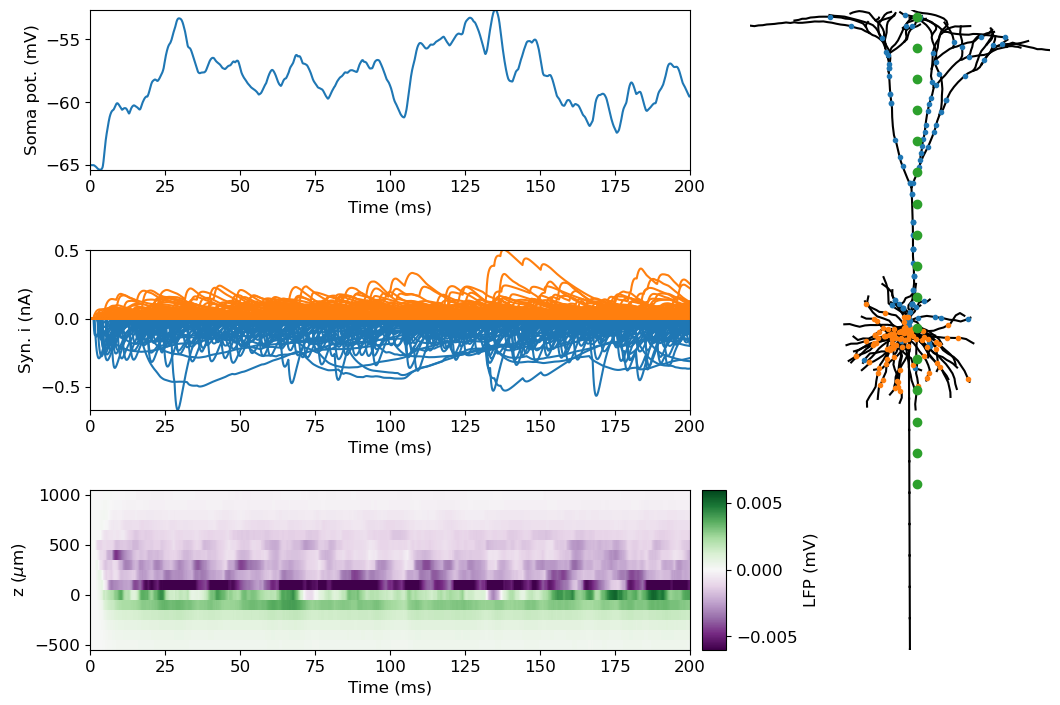

In [8]:
#plotting some variables and geometry, saving output to .pdf.
from example_suppl import plot_ex3
fig = plot_ex3(cell, electrode)
#fig.savefig('LFPy-example-09.pdf', dpi=300)